In [143]:
# required imports 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import requests
import plotly.express as px 
import seaborn as sns

# modeling requirements
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor


In [144]:
# read in data
haiti_df = pd.read_csv('Haiti_EQ.csv')
puerto_rico_df = pd.read_csv('Puerto_Rico_EQ.csv')
haiti_df.head(5)

,time,latitude,longitude,depth,mag,magType,nst,gap,dmin,rms,...,depthError,magError,magNst,status,locationSource,magSource,"city,region",dist_se,city,country
0,2018-12-16 16:15:45.350000+00:00,18.6468,-72.0948,10.00,3.5,ml,NaN,80.0,0.230,0.47,...,2.0,0.071,26.0,reviewed,us,us,"Thomazeau, Haiti",0.0,Thomazeau,Haiti
1,2018-10-17 02:05:26+00:00,20.0612,-72.9869,12.64,4.4,mb,NaN,52.0,1.662,0.94,...,4.2,0.098,30.0,reviewed,us,us,"Port-de-Paix, Haiti",21.0,Port-de-Paix,Haiti
2,2018-10-08 05:04:26.610000+00:00,20.2143,-72.9239,10.00,4.4,mb,NaN,79.0,1.783,0.49,...,1.9,0.148,13.0,reviewed,us,us,"Port-de-Paix, Haiti",31.0,Port-de-Paix,Haiti
3,2018-10-07 20:00:18.890000+00:00,20.0414,-73.0143,23.00,5.4,mww,NaN,27.0,1.655,1.13,...,1.9,0.054,33.0,reviewed,us,us,"Port-de-Paix, Haiti",22.0,Port-de-Paix,Haiti
4,2018-10-07 00:11:51.220000+00:00,20.0343,-73.0128,24.00,5.9,mww,NaN,19.0,1.648,0.70,...,1.4,0.055,32.0,reviewed,us,us,"Port-de-Paix, Haiti",21.0,Port-de-Paix,Haiti


In [145]:
# save copies
haiti = haiti_df
puerto_rico = puerto_rico_df

In [146]:
# mag normalization function

def mag_norm(df):
    # normalizing magnitudes based on literature
    if any(x in df['magType'] for x in ['ML', 'ml']) and df['mag'] > 3.8:
        return 0.98*df.mag + 0.19
    if any(x in df['magType'] for x in ['ML', 'ml']) and df['mag'] <= 3.8:
        return (2/3)*df.mag + 1.15
    if any(x in df['magType'] for x in ['Mb', 'mb']):
        return (0.85)*df.mag + 1.02
    if any(x in df['magType'] for x in ['Md', 'md']):
        return (0.93)*df.mag + 0.35
    else:
        return df.mag

In [147]:
# adding log energy released column 

def energy_released(df):
    df = df.copy()
    df['log_e_released'] = (5.24 + 1.44*df.mag_norm)
    return df


In [148]:
haiti['mag_norm'] = haiti.apply(lambda x: mag_norm(x), axis=1)
puerto_rico['mag_norm'] = puerto_rico.apply(lambda x: mag_norm(x), axis=1)

In [149]:
mod_haiti = energy_released(haiti)
mod_pr = energy_released(puerto_rico)

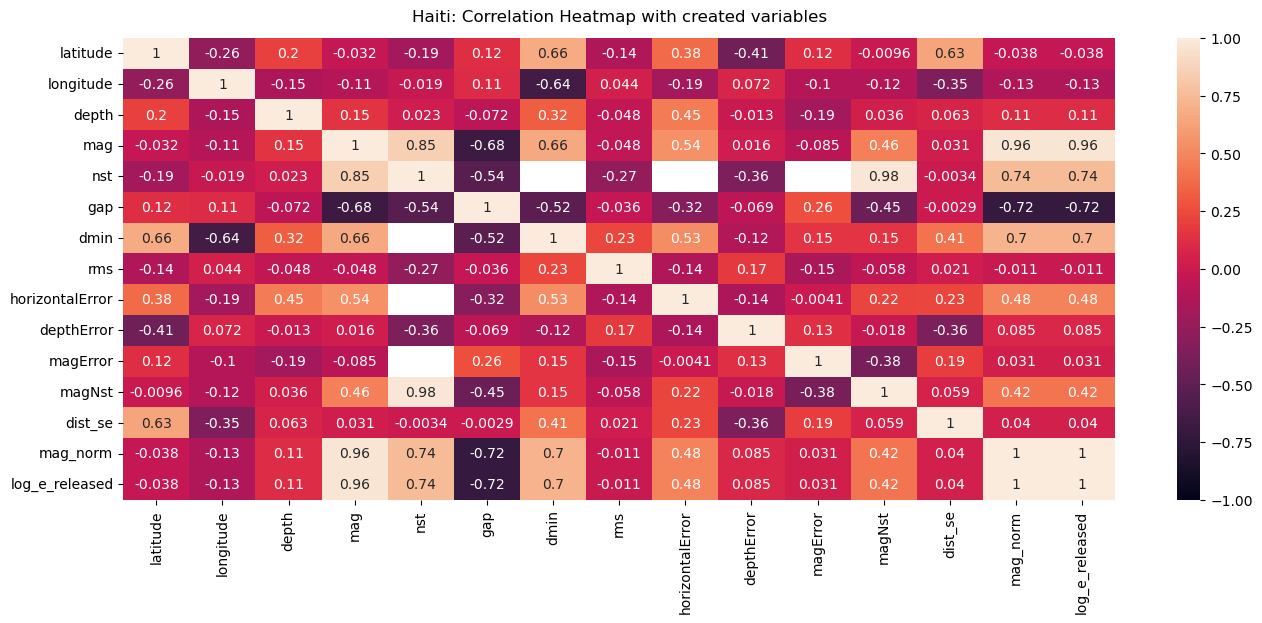

In [150]:
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(mod_haiti.corr(), vmin=-1, vmax=1, annot=True);

heatmap.set_title('Haiti: Correlation Heatmap with created variables', fontdict={'fontsize':12}, pad=12);


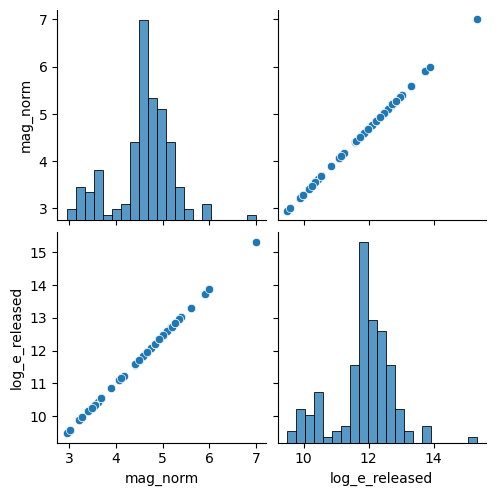

In [151]:
m_d = mod_haiti[['mag_norm', 'log_e_released']]
sns.pairplot(m_d, kind='scatter')
plt.show()

### Models for Puerto Rico

In [164]:
# random forest regressor 
# predicting EQ depth from mag_norm

X_vars = mod_pr[['latitude','longitude','mag_norm', 'log_e_released']]
target = mod_pr['depth']
X_train, X_test, y_train, y_test = train_test_split(X_vars, target, test_size=0.40)

rf_params = {
    'n_estimators': [200,300,350,400],
    'max_features': ['auto','sqrt', 'log2'],
    'max_depth': [int(x) for x in np.linspace(5, 100, num = 5)]
    }
rf = RandomForestRegressor() 
rf_rscv = RandomizedSearchCV(estimator=rf, param_distributions=rf_params,
n_iter=20, cv=3, verbose=False, random_state=42)



In [165]:
# rf model fitting 
rf_rscv.fit(X_train, y_train)

/Users/cassak1/opt/anaconda3/envs/mlclimate/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/cassak1/opt/anaconda3/envs/mlclimate/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/cassak1/opt/anaconda3/envs/mlclimate/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `ma

RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(), n_iter=20,
                   param_distributions={'max_depth': [5, 28, 52, 76, 100],
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'n_estimators': [200, 300, 350, 400]},
                   random_state=42, verbose=False)

In [166]:
# PR: random forest performance

print(f'best params:{rf_rscv.best_params_}')
print(f'r_sq training:{rf_rscv.score(X_train, y_train)}')
print(f'r_sq test:{rf_rscv.score(X_test, y_test)}')


best params:{'n_estimators': 300, 'max_features': 'sqrt', 'max_depth': 28}
r_sq training:0.9075713645214314
r_sq test:0.36273149470385635


In [171]:
# predictions
#for x in range(200,400):
#y_pred = rf_rscv.predict(X_test)
#plt.plot(range(100,400), y_pred)